In [47]:
#essential libraries
import pandas as pd                   #pandas does things with matrixes
import numpy as np                    #used for sorting a matrix
import matplotlib.pyplot as plt       #matplotlib is used for plotting data
import matplotlib.ticker as ticker    #used for changing tick spacing
import datetime as dt                 #used for dates
import matplotlib.dates as mdates     #used for dates, in a different way

In [48]:
from fbprophet import Prophet

# Statsmodels widely known for forecasting than Prophet

import statsmodels.api as sm
from scipy import stats
#from pandas.core import datetools
#from plotly import tools
#import plotly.plotly as py
#import plotly.figure_factory as ff
#import plotly.tools as tls
#import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

# plt.style.available
plt.style.use("seaborn-whitegrid")

In [49]:
#importing dataset
df = pd.read_csv('../input/sandp500/all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


# understanding our dataset

The first step towards data analysis is to understand the data in hand. Its columns, max, min, count, null values, etc...

In [50]:
df.columns                     #prints just the columns of the matrix

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [51]:
df.info()                            #get information of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [52]:
df.describe()                        #describe the dataset

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


# Missing values
In this section we will handle all the missing data in the dataset

In [53]:
total = df.isnull().sum().sort_values()                                              #counts all null cells in a row
percent = ((df.isnull().sum()/df.isnull().count()).sort_values()*100)                #sees what percent of the data is null
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])            #combines the two matrixies
missing_data                                                                         #this displays the matrix

,Total,Percent
date,0,0.000000
close,0,0.000000
volume,0,0.000000
Name,0,0.000000
high,8,0.001292
low,8,0.001292
open,11,0.001777


We observe that the total number of column with missing values is 8-27 which is less that 0.005% of the dataset.
It is convinient to get rid of the rows with missing value since the affect on the dataset will be very insignificant, but to avoid any issues since it is a time series analysis, we will forward fill the null values instead of dropping them.

In [54]:
df = df.ffill(axis=1)                                   #forward filling rows with a null cell


Let's check the missing data again

In [55]:
total = df.isnull().sum().sort_values()                                              #counts all null cells in a row
percent = ((df.isnull().sum()/df.isnull().count()).sort_values()*100)                #sees what percent of the data is null
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])            #combines the two matrixies
missing_data  

,Total,Percent
date,0,0.0
open,0,0.0
high,0,0.0
low,0,0.0
close,0,0.0
volume,0,0.0
Name,0,0.0


We observe that the total number of missing rows to be 11, making the total number of rows being deleted less than 0.002% of the dataset.

In [56]:
df = df.drop(df.loc[df['open'].isnull()].index)                                   #drops rows with a null cell in the open column
total = df.isnull().sum().sort_values()                                              #counts all null cells in a row
percent = ((df.isnull().sum()/df.isnull().count()).sort_values()*100)                #sees what percent of the data is null
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])            #combines the two matrixies
missing_data  

,Total,Percent
date,0,0.0
open,0,0.0
high,0,0.0
low,0,0.0
close,0,0.0
volume,0,0.0
Name,0,0.0


we have ***successfully*** cleared all missing data from our dataset

# Exploratory Data Analysis

Let's analyse, plot and work on different aspects of the project

In [57]:
len(df.Name.unique())                  #calculating total number of companies listed in the dataset

505

# Feature Extraction

In [58]:
# For the sake of visualization, Let's create extract year from the date column
df['year'] = pd.DatetimeIndex(df["date"]).year
df['month'] = pd.DatetimeIndex(df["date"]).month
df['date'] = pd.DatetimeIndex(df["date"]).date

In [59]:
df.tail()

,date,open,high,low,close,volume,Name,year,month
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,2018,2
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,2018,2
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,2018,2
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,2018,2
619039,2018-02-07,72.7,75,72.69,73.86,4534912,ZTS,2018,2


In [60]:
#Since the year 2017 is the most recent year with dataset of over 4 months, let's explore that
# Creating a ColumnDataSource instance to act as a reusable data source for ploting


In [61]:
df["Name"].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

In [62]:
#We'll focus on one
walmart = df.loc[df['Name'] == 'WMT']
walmart.head()

,date,open,high,low,close,volume,Name,year,month
595716,2013-02-08,71.2,71.64,71.07,71.48,5906823,WMT,2013,2
595717,2013-02-11,71.25,71.51,70.53,71.4,6202534,WMT,2013,2
595718,2013-02-12,71.49,71.66,71.1,71.4,4761910,WMT,2013,2
595719,2013-02-13,71.29,71.7,71.21,71.39,3969807,WMT,2013,2
595720,2013-02-14,71.1,71.23,70.755,70.82,6820952,WMT,2013,2


We need to make sure if the date column is either a categorical type or a datetype. In our case date is a categorical datatype so we need to change it to datetime.

In [63]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 595716 to 596974
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1259 non-null   object
 1   open    1259 non-null   object
 2   high    1259 non-null   object
 3   low     1259 non-null   object
 4   close   1259 non-null   object
 5   volume  1259 non-null   object
 6   Name    1259 non-null   object
 7   year    1259 non-null   int64 
 8   month   1259 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 98.4+ KB


In [64]:
#Create a copy to avoid the SettingWarning .loc issue 
walmart_df = walmart.copy()

# Change to datetime datatype.
walmart_df.loc[:, 'date'] = pd.to_datetime(walmart.loc[:,'date'], format="%Y/%m/%d")

In [65]:
walmart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 595716 to 596974
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   object        
 2   high    1259 non-null   object        
 3   low     1259 non-null   object        
 4   close   1259 non-null   object        
 5   volume  1259 non-null   object        
 6   Name    1259 non-null   object        
 7   year    1259 non-null   int64         
 8   month   1259 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 98.4+ KB


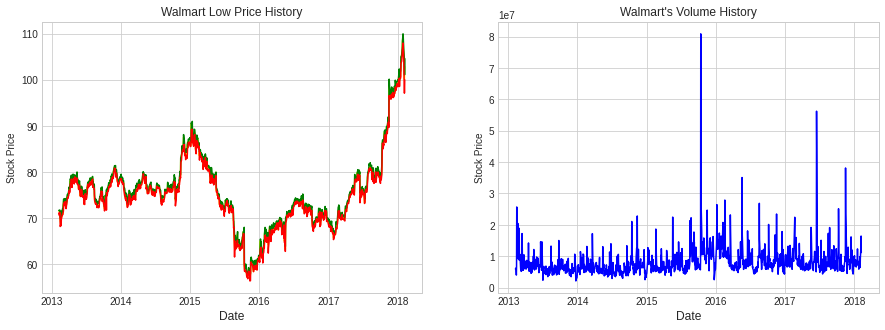

In [66]:
# Let us plot Walmart Stock Price
# First Subplot

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(walmart_df["date"], walmart_df["close"], color="yellow")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Walmart Close Price History")

# Second Subplot
ax1.plot(walmart_df["date"], walmart_df["high"], color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Walmart High Price History")

# Third Subplot
ax1.plot(walmart_df["date"], walmart_df["low"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Walmart Low Price History")

# Fourth Subplot
ax2.plot(walmart_df["date"], walmart_df["volume"], color="blue")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Walmart's Volume History")

plt.show()

While studying the pattern and analysing the market shares through visualizations, we can notice a sharp increase in the prices of walmarts stock prices indicating profits and revenue in the year 2017-18

# Understanding Facebook's Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.



In [67]:
m = Prophet()

# Drop the columns
ph_df = walmart_df.drop(['open', 'high', 'low','volume', 'Name', "year", "month"], axis=1)
ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

ph_df.head()

,ds,y
595716,2013-02-08,71.48
595717,2013-02-11,71.4
595718,2013-02-12,71.4
595719,2013-02-13,71.39
595720,2013-02-14,70.82


In [68]:
m.fit(ph_df)

In [69]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=2000)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3254,2023-07-27,300.154168,-130.052379,716.261212
3255,2023-07-28,300.178344,-130.060410,718.840844
3256,2023-07-29,301.740663,-129.845418,719.297348
3257,2023-07-30,301.812736,-128.155303,720.097985
3258,2023-07-31,300.444717,-130.089828,718.523470


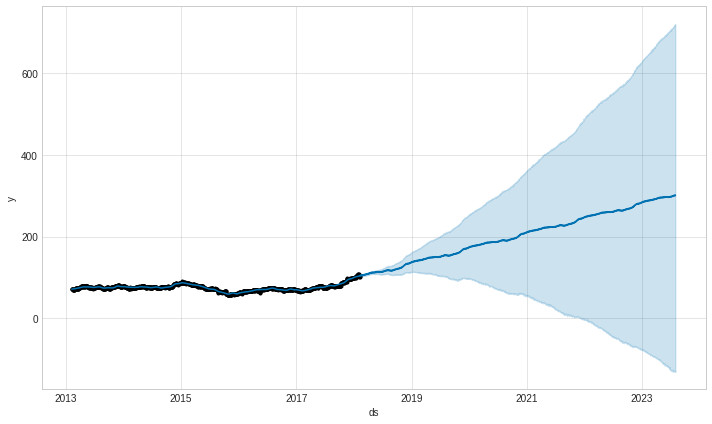

In [70]:
import matplotlib.dates as mdates

# Dates

starting_date = dt.datetime(2018, 4, 7)
starting_date1 = mdates.date2num(starting_date)
trend_date = dt.datetime(2018, 6, 7)
trend_date1 = mdates.date2num(trend_date)

pointing_arrow = dt.datetime(2018, 2, 18)
pointing_arrow1 = mdates.date2num(pointing_arrow)

# Learn more Prophet tomorrow and plot the forecast for walmart.
fig = m.plot(forecast)
#ax1 = fig.add_subplot(111)
ax1.set_title("Walmart Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

# Forecast initialization arrow
ax1.annotate('Forecast \n Initialization', xy=(pointing_arrow1, 1350), xytext=(starting_date1,1700),
            arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
            )

# Trend emphasis arrow
ax1.annotate('Upward Trend', xy=(trend_date1, 1225), xytext=(trend_date1,950),
            arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
            )

ax1.axhline(y=1260, color='b', linestyle='-')

plt.show()

In [85]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='500 days', period='30 days', horizon = '365 days')

In [83]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,19.246776,4.387115,3.391623,0.047992,0.037759,0.270347
1,38 days,20.480473,4.525536,3.505897,0.049607,0.038717,0.264656
2,39 days,21.436310,4.629936,3.595053,0.050875,0.039496,0.255976
3,40 days,21.741698,4.662799,3.641851,0.051499,0.039496,0.246443
4,41 days,22.274504,4.719587,3.700416,0.052310,0.039840,0.239613


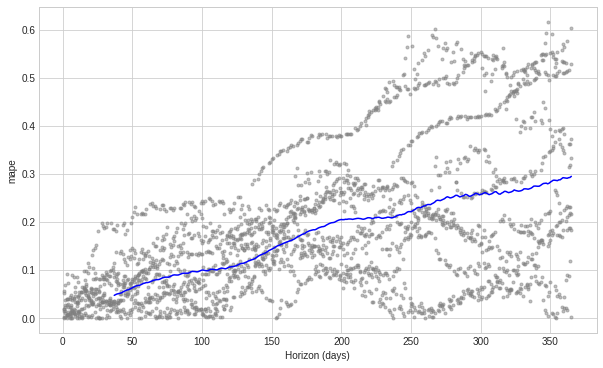

In [84]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')